# Transfert Learning Using VGG16

# Grid Search

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from glob import glob
from sklearn.base import BaseEstimator, ClassifierMixin

# Répertoires des données
base_dir = 'real_and_fake_face'
real_dir = os.path.join(base_dir, 'training_real')
fake_dir = os.path.join(base_dir, 'training_fake')

# Charger les images et les étiquettes
real_images_path = os.path.join(real_dir, '*.jpg')
fake_images_path = os.path.join(fake_dir, '*.jpg')

real_images = glob(real_images_path)
fake_images = glob(fake_images_path)

images_path = np.concatenate([real_images, fake_images], axis=0)
labels = np.concatenate([np.zeros(len(real_images)), np.ones(len(fake_images))], axis=0)

# Préparer les données d'entraînement et de test
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)  # One-hot encode the labels

(train_images, test_images, train_labels, test_labels) = train_test_split(images_path, labels, test_size=0.2, random_state=42)

# Transform labels to single class format
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Charger et prétraiter les images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

train_images = np.vstack([preprocess_image(img) for img in train_images])
test_images = np.vstack([preprocess_image(img) for img in test_images])

# Définir la fonction pour créer le modèle
def create_model(learning_rate=1e-3, hidden_layers=1, hidden_units=256):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    flat = Flatten()(base_model.output)
    for _ in range(hidden_layers):
        flat = Dense(hidden_units, activation='relu')(flat)
    output = Dense(2, activation='softmax')(flat)

    new_model = Model(inputs=base_model.input, outputs=output)
    new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

# Custom Keras Classifier
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, **sk_params):
        self.build_fn = build_fn
        self.sk_params = sk_params
        self.model = None

    def fit(self, X, y, **kwargs):
        build_params = {k: v for k, v in self.sk_params.items() if k in ['learning_rate', 'hidden_layers', 'hidden_units']}
        train_params = {k: v for k, v in self.sk_params.items() if k in ['epochs', 'batch_size']}
        print(f"Training with parameters: {build_params} and training parameters: {train_params}")  # Print parameters
        self.model = self.build_fn(**build_params)
        self.model.fit(X, tf.keras.utils.to_categorical(y), **train_params, **kwargs)
        return self

    def predict(self, X, **kwargs):
        probas = self.model.predict(X, **kwargs)
        return np.argmax(probas, axis=1)  # Return the class with highest probability

    def predict_proba(self, X, **kwargs):
        return self.model.predict(X, **kwargs)

    def get_params(self, deep=True):
        return {"build_fn": self.build_fn, **self.sk_params}

    def set_params(self, **params):
        if "build_fn" in params:
            self.build_fn = params.pop("build_fn")
        self.sk_params.update(params)
        return self

# Paramètres pour la recherche de grille
params = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'hidden_layers': [1, 2, 3],
    'hidden_units': [256, 512, 1024],
    'epochs': [1],  # Only one epoch
    'batch_size': [16]
}

# Créer le modèle TensorFlow pour scikit-learn
model = CustomKerasClassifier(build_fn=create_model, verbose=1)

# Effectuer la recherche de grille
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=1)
grid_search.fit(train_images, train_labels)

# Afficher les meilleurs paramètres
print("Best parameters found: ", grid_search.best_params_)

# Évaluer le meilleur modèle
best_model = grid_search.best_estimator_
best_model.fit(train_images, train_labels, epochs=1, batch_size=16)
predictions = best_model.predict(test_images)
print(classification_report(test_labels, predictions, target_names=lb.classes_))


D'accord, je vais expliquer chaque partie du code sans le réécrire.

### Importation des bibliothèques
Le script commence par importer les bibliothèques nécessaires pour le traitement des images, la création de modèles de réseau de neurones, et l'évaluation des performances. Cela inclut TensorFlow/Keras pour le deep learning, scikit-learn pour l'évaluation et l'optimisation des hyperparamètres, et d'autres utilitaires.

### Définition des répertoires des données
Les chemins des répertoires où se trouvent les images réelles et fausses sont définis. Cela permet de charger les images à partir de ces répertoires plus tard dans le code.

### Chargement des images et des étiquettes
Les chemins des fichiers images sont récupérés à l'aide de glob. Ensuite, les chemins des images réelles et fausses sont concaténés pour former un seul ensemble de chemins d'images, et des étiquettes (0 pour réel, 1 pour faux) sont créées pour chaque image.

### Préparation des données d'entraînement et de test
Les étiquettes sont binarisées pour convertir les étiquettes de classe en format one-hot encoding, ce qui est requis pour l'entraînement du modèle. Ensuite, les données (images et étiquettes) sont divisées en ensembles d'entraînement et de test.

### Fonction de prétraitement des images
Une fonction est définie pour charger une image à partir d'un chemin donné, la redimensionner à 224x224 pixels (taille attendue par le modèle VGG16), la convertir en tableau numpy, et appliquer le prétraitement spécifique à VGG16.

### Définition de la fonction pour créer le modèle
Une fonction est définie pour créer un modèle basé sur VGG16. VGG16 est utilisé comme base, et des couches fully connected sont ajoutées pour la classification binaire (réel ou faux). Le modèle est compilé avec l'optimiseur Adam et la perte categorical_crossentropy.

### Définition d'un classificateur Keras personnalisé
Une classe personnalisée `CustomKerasClassifier` est définie pour intégrer le modèle Keras dans l'API de scikit-learn. Cette classe implémente les méthodes nécessaires pour être compatible avec GridSearchCV, comme `fit`, `predict`, `predict_proba`, `get_params`, et `set_params`.

### Définition des paramètres pour la recherche en grille
Un dictionnaire de paramètres est défini pour la recherche en grille. Les hyperparamètres à tester incluent le taux d'apprentissage, le nombre de couches cachées, le nombre de neurones par couche cachée, le nombre d'époques et la taille du lot.

### Création et exécution de la recherche en grille
Le classificateur Keras personnalisé est instancié et utilisé comme estimateur pour GridSearchCV. GridSearchCV effectue une recherche exhaustive des meilleurs hyperparamètres en utilisant une validation croisée à 3 plis.

### Affichage des meilleurs paramètres
Les meilleurs paramètres trouvés par GridSearchCV sont imprimés.

### Évaluation du meilleur modèle
Le meilleur modèle trouvé par la recherche en grille est réentraîné sur l'ensemble d'entraînement, puis évalué sur l'ensemble de test. Les prédictions sont faites sur les données de test, et un rapport de classification est généré, affichant des métriques telles que la précision, le rappel et le F1-score pour chaque classe.

# Équilibrage des Données
Le code ci-dessous équilibre les données en créant des répertoires équilibrés avec un nombre égal d'images réelles et fausses :

In [1]:
import os
import numpy as np
from sklearn.utils import resample
import shutil

# Répertoires des données
base_dir = 'C:\\Users\\n.benabderrahmane\\OneDrive - Datanumia\\Bureau\\DD\\DEEP_FAKE_DETECTION\\real_and_fake_face'
real_dir = os.path.join(base_dir, 'training_real')
fake_dir = os.path.join(base_dir, 'training_fake')

# Créer des répertoires équilibrés pour le dataset
balanced_base_dir = 'balanced_dataset'
balanced_real_dir = os.path.join(balanced_base_dir, 'training_real')
balanced_fake_dir = os.path.join(balanced_base_dir, 'training_fake')

os.makedirs(balanced_real_dir, exist_ok=True)
os.makedirs(balanced_fake_dir, exist_ok=True)

# Lister les fichiers
real_images = os.listdir(real_dir)
fake_images = os.listdir(fake_dir)

# Équilibrer les données
n_fake = len(fake_images)
real_images_balanced = resample(real_images, replace=False, n_samples=n_fake, random_state=42)

# Copier les images équilibrées dans les nouveaux répertoires
for img in real_images_balanced:
    shutil.copy(os.path.join(real_dir, img), os.path.join(balanced_real_dir, img))

for img in fake_images:
    shutil.copy(os.path.join(fake_dir, img), os.path.join(balanced_fake_dir, img))

print(f"Nombre d'images équilibrées: {n_fake} réelles et {n_fake} fausses.")


Nombre d'images équilibrées: 960 réelles et 960 fausses.


# Préparation des Données
Le code ci-dessous charge et prétraite les images du répertoire équilibré pour les utiliser dans l'entraînement du modèle :

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Préparer le générateur de données avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    balanced_base_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    balanced_base_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


# Création du Modèle
Le code suivant crée un modèle basé sur VGG16 avec les hyperparamètres déterminés précédemment :

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [31]:
# Débloquer certaines couches du modèle VGG16 pour Fine-Tuning et ajouter des couches de convolution supplémentaires
def create_finetune_model_with_conv(learning_rate=0.0001, hidden_layers=1, hidden_units=256, dropout_rate=0.5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Débloquer les dernières couches de VGG16
    for layer in base_model.layers[-4:]:
        layer.trainable = True
    
    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    for _ in range(hidden_layers):
        x = Dense(hidden_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    output = Dense(2, activation='softmax')(x)

    new_model = Model(inputs=base_model.input, outputs=output)
    new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

model = create_finetune_model_with_conv()


In [32]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Sauvegarder le modèle
model.save('deepfake_detection_model_with_conv.h5')


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 928s 10s/step - accuracy: 0.4943 - loss: 0.7212 - val_accuracy: 0.5078 - val_loss: 0.6931
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - accuracy: 0.4827 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
26/96 ━━━━━━━━━━━━━━━━━━━━ 9:19 8s/step - accuracy: 0.4884 - loss: 0.6932

# Entraînement du Modèle et Enregistrement des Métriques
Le code ci-dessous entraîne le modèle sur les données préparées pendant 10 époques et enregistre les métriques :

In [ ]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Sauvegarder le modèle
model.save('deepfake_detection_model.h5')


Epoch 1/10


c:\Users\n.benabderrahmane\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6015 - loss: 0.7008 - val_accuracy: 0.5286 - val_loss: 0.7932
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7277 - loss: 0.5412 - val_accuracy: 0.5443 - val_loss: 0.8472
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8197 - loss: 0.4115 - val_accuracy: 0.5391 - val_loss: 0.9253
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2792s 29s/step - accuracy: 0.8660 - loss: 0.3120 - val_accuracy: 0.5286 - val_loss: 1.1359
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.9310 - loss: 0.1753 - val_accuracy: 0.5312 - val_loss: 1.2414
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9691 - loss: 0.1080 - val_accuracy: 0.5417 - val_loss: 1.4923
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9804 - loss: 0.0700 - val_accuracy: 0.5260 - val_loss: 1.8419
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9855 - loss: 0.0487 - val_accuracy: 0.5156 - val_loss: 

# Affichage des Courbes de Performance
Le code suivant affiche les courbes d'accuracy et de loss au fil des époques :

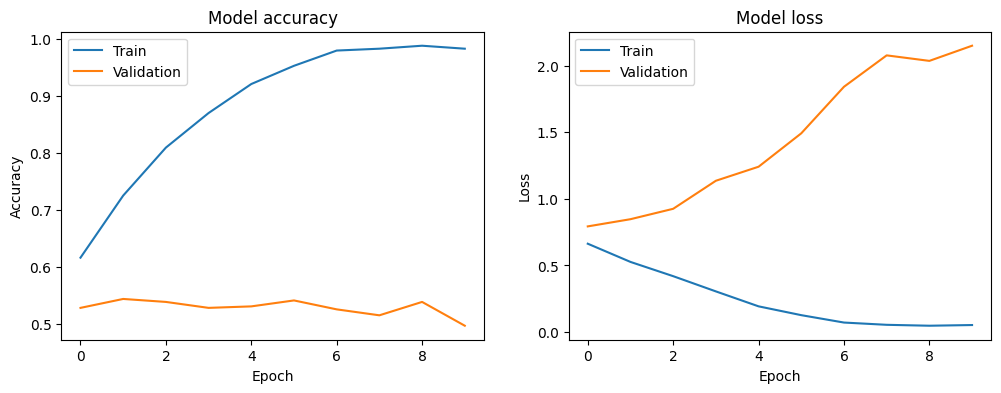

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Malgré la grid searhc on tombe sur un modèle overfité, faut elargir la grid search

# Évaluation Globale
Le code suivant évalue les performances globales du modèle sur les données de validation :

In [ ]:
# Évaluation globale du modèle
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4957 - loss: 2.1504
Validation loss: 2.1502685546875
Validation accuracy: 0.4973958432674408


# Matrice de Confusion
Le code suivant affiche la matrice de confusion :

25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


c:\Users\n.benabderrahmane\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


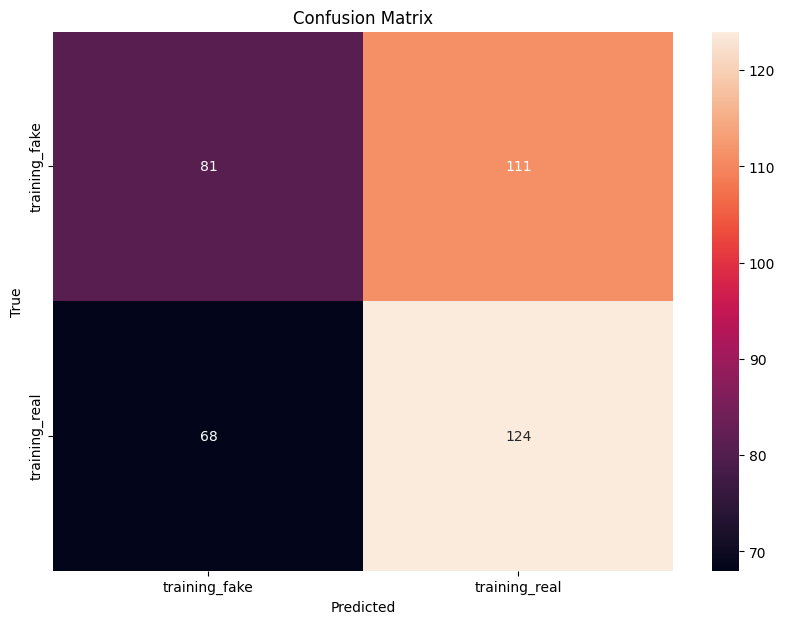

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prédictions sur les données de validation
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Courbe ROC
Le code suivant trace la courbe ROC pour évaluer les performances du modèle :

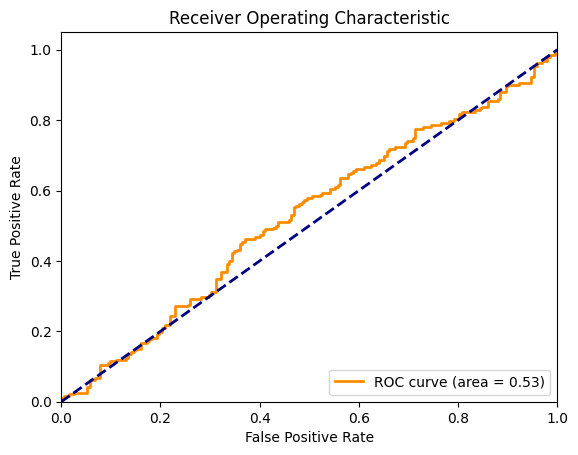

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(true_classes, predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Chargement du Modèle et Prédictions
Le code ci-dessous charge le modèle enregistré et effectue des prédictions sur de nouvelles images/vidéos :


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Charger le modèle
model = load_model('deepfake_detection_model.h5')

# Fonction de prétraitement des images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalisation
    return img

# Exemple de prédiction sur une nouvelle image
image_path = 'real_and_fake_face_detection/real_and_fake_face/training_fake/easy_1_1110.jpg'
image = preprocess_image(image_path)
prediction = model.predict(image)
print(f'Prediction: {np.argmax(prediction)}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Prediction: 1
